## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

/media/systemmind/SharedVolume/education/mipt/machine_learning/env/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes),
            nn.BatchNorm1d(num_classes),
            nn.ReLU(),
            nn.LogSoftmax()
        )

    def forward(self, inp):       
        return self.model(inp)

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

/media/systemmind/SharedVolume/education/mipt/machine_learning/env/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
       BatchNorm1d-3                   [-1, 10]              20
              ReLU-4                   [-1, 10]               0
        LogSoftmax-5                   [-1, 10]               0
Total params: 7,870
Trainable params: 7,870
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


Your experiments come here:

In [ ]:
from tqdm import tqdm

model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

In [10]:
from tqdm import tqdm

def train_model(model, times, train_loader, test_loader, loss_func, opt, device):
  train_loss = []
  test_loss = []

  bar = tqdm(range(times))
  for _ in bar:
    bar.set_description(f'Loss: {train_loss[-1] if train_loss else 0.0}')

    model.train()
    train_loss_tmp = []
    for img, label in train_loader:
      opt.zero_grad()
      img = img.to(device)
      label = label.to(device)

      predicts = model(img)
      loss = loss_func(predicts, label)
      loss.backward()
      opt.step()
      train_loss_tmp.append(loss.item())

    train_loss.append(np.mean(train_loss_tmp))

    model.eval()
    train_loss_tmp = []
    for img, label in test_loader:
      img = img.to(device)
      label = label.to(device)

      predicts = model(img)
      loss = loss_func(predicts, label)
      train_loss_tmp.append(loss.item())

    test_loss.append(np.mean(train_loss_tmp))

  return train_loss, test_loss

In [15]:
EPOCHES = 50

In [11]:
train_loss, test_loss = train_model(model, EPOCHES, train_loader, test_loader, loss_func, opt, device)

Loss: 0.5040322885330297: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.33s/it]


In [16]:
def draw_model_plot(epochs, title, train_loss, test_loss):
  fig, axes = plt.subplots(1, 1, figsize=(8, 8))

  plt.title(title)

  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.yscale('log')

  plt.plot(range(epochs), torch.Tensor(train_loss), label='Train')
  plt.plot(range(epochs), torch.Tensor(test_loss), label='Test')
  plt.grid()
  plt.legend()

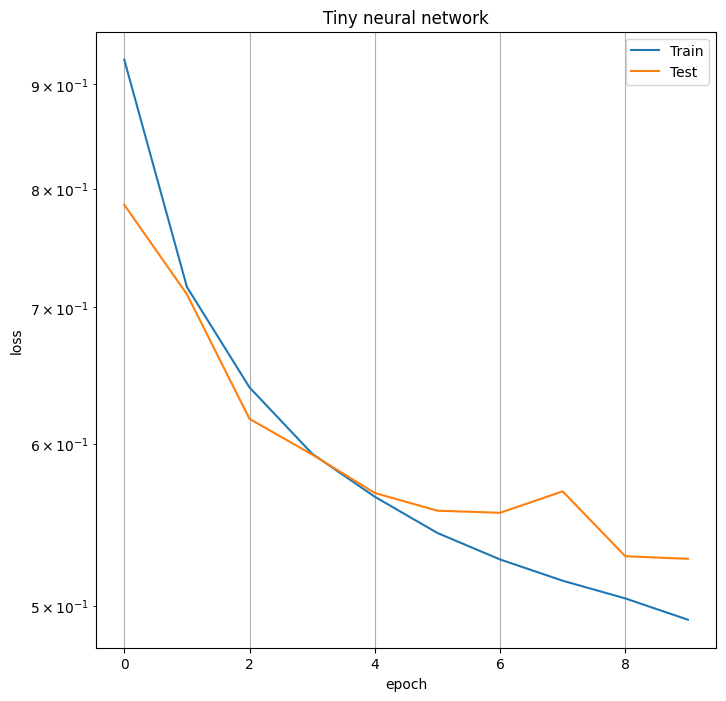

In [17]:
draw_model_plot(EPOCHES, 'Tiny neural network', train_loss, test_loss)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [55]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        args = (nn.Linear(512, 512), nn.ReLU()) * 5
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            *args,
            nn.LogSoftmax()
        )

    def forward(self, inp):       
        return self.model(inp)

In [56]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.NLLLoss()

train_loss, test_loss = train_model(model, 100, train_loader, test_loader, loss_func, opt, device)

Loss: 0.16169176763817192: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:51<00:00,  6.51s/it]


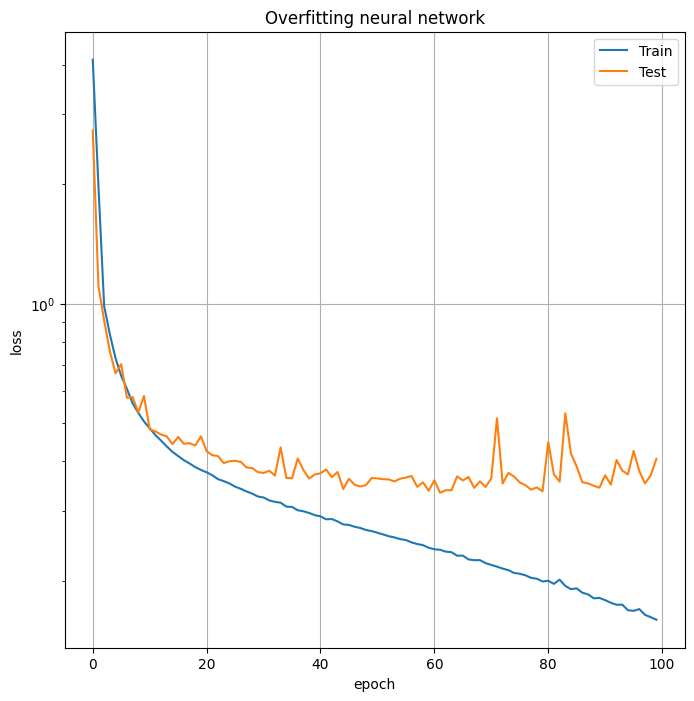

In [57]:
draw_model_plot(100, 'Overfitting neural network', train_loss, test_loss)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [60]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        args = (nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout1d(p=0.5), nn.Linear(512, 512), nn.ReLU()) * 5
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            *args,
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [61]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
train_loss, test_loss = train_model(model, 100, train_loader, test_loader, loss_func, opt, device)

Loss: 2.275846449805221: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:14<00:00,  7.34s/it]


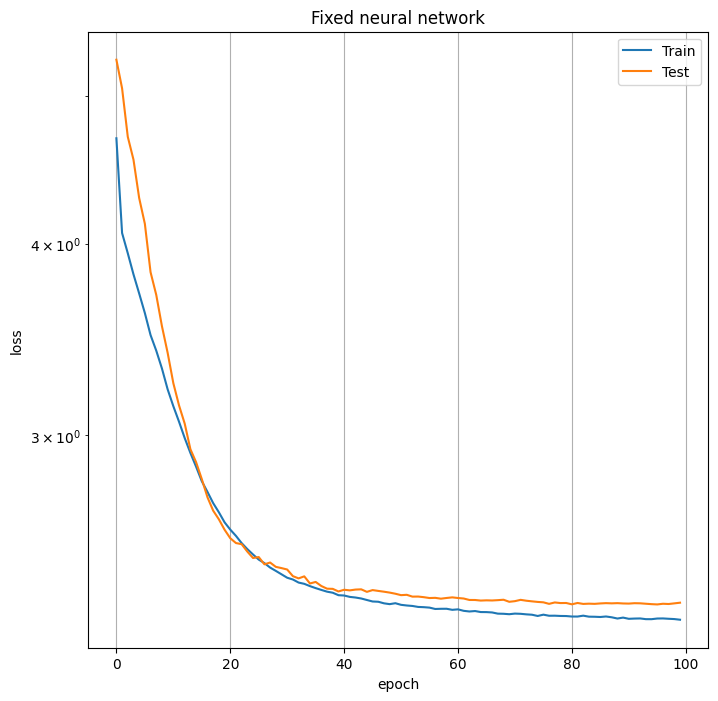

In [77]:
draw_model_plot(100, 'Fixed neural network', train_loss, test_loss)

In [ ]:
def print_accuracy(title, loader, model):
  accuracy = 0.0
  correct, total = 0, 0

  for image, label in loader:
    image = image.to(device)
    label = label.to(device)
        
    preds = model(image).argmax(axis=1)
    correct += (preds == label).sum().item()
    total += len(label)

  accuracy = correct / total

  print(title, accuracy)

In [86]:
print_accuracy('Train accuracy', train_loader, model)
print_accuracy('Test accuracy', test_loader, model)

Train accuracy 0.12593333333333334
Test accuracy 0.1282


### Conclusions:

В ходе лабораторной работы построили простую последовательную (sequential) нейросеть, после чего сделали похожую сеть и переобучили ее, после чего поытались исправить переобучение с помощью нормализации (BatchNorm) и дропаутов. Судя по графикам, переобучение действительно произошло, т.к. ошибка на тренировочных данных получилась значительно ниже, чем на тестовых, и судя по последнему графику нам действительно удалось это переобучение уменьшить т.к. разрыв между двумя графиками значительно сократился. К сожалению, акураси упал ниже плинтуса, но это скорее всего связано с тем, что я добавил очень много слоев в последние две нейросети. К сожалению не успеваю исправить это и поэтому оставляю как есть.